In [ ]:
"""
In this notebook there are four main cells

Cell 1 creates a QUBO Adjacency to represent the ambulance problem, it involves constraints and minimising distance driven.
Cell 2 Defines the methods used in Cell 3, and converts QUBO Adjacency to the dwave type bqm that can be sampled 
Cell 3 Finds the minimum energy for a given starting postion of two ambulances, using a choice of a) dimod.ExactSolver() b)neal.SimulatedAnnealingSampler()   or c) DWaveSampler() the live QPU not a simulator or d) TabuSampler()
cell 4 Classically iterates over all possible starting position of two ambulances and selects the lowest energy of them all and which destination are allocated to each of the two ambulances.

In [35]:
#TWO AMBULANCE DISTANCE MINIMISATION - 

import numpy as np 
#RC utility functions    
from pyaqc.RCModules.PlatformConversion import print_QUBOdetails, CreateTwoAmbulanceAdjacencyV1,CreateTwoAmbulanceAdjacencyV2
#################################### Create Adjacency defined as a qubo ####################################
n_destinations = 3*2
gridWidth = 3# n_destinations
Width  = gridWidth
Height = n_destinations//gridWidth

result = CreateTwoAmbulanceAdjacencyV2(gridWidth,n_destinations, Adddistance = 1, ConstraintMultiplier=5, use_XYMixer_constraints=0)

Adjacency = result['qubo']
AdjacencyHybrid = result['quboHybrid']
n_qubits = result['n_qubits']
ConstraintMultiplier = result['ConstraintMultiplier']
max_distance = result['max_distance']

print(ConstraintMultiplier/max_distance ,' = ConstraintMultiplier/max_distance')
if 1:
    filename = 'Twoambulances.txt'
    
    print_QUBOdetails(Adjacency,n_qubits,filename)

1.0  = ConstraintMultiplier/max_distance
ADJACENCY MATRIX Twoambulances.txt  

Qubit  q0   q1   q2   q3   q4   q5   q6   q7   q8   q9  q10  q11  q12  q13  q14  q15  q16  q17  q18  q19  q20  q21  q22  q23 

  q0   -5                            10                                 1    4    1    2    5  

  q1        -5                            10                       1         1    2    1    2  

  q2             -5                            10                  4    1         5    2    1  

  q3                  -5                            10             1    2    5         1    4  

  q4                       -5                            10        2    1    2    1         1  

  q5                            -5                            10   5    2    1    4    1  

  q6                                 -5                                                               1    4    1    2    5  

  q7                                      -5                                              

In [36]:
# Two useful functions
import matplotlib.pyplot as plt
import dimod
samplerExact = dimod.ExactSolver()
def lowest_energy_num_occ(response, atol:'tolerance'=0):
    """
    Returns (type:float) the number of samples in the 'response' (type:sample_set) with energies < lowest_energy + atol
    params:  'response' (type:sample_set)
              'atol' (type:float)
          
    """
    num_occ = 0
    for data in  response.data(['num_occurrences','energy']):
            if data.energy < response.first[1]+ atol :
                num_occ += data.num_occurrences
#                print(data.energy)
            else:
#                print(data.energy)
                break
    return num_occ
        
def create_hybrid_from(Adjacency, Nlocs,A0_fix ,A1_fix ):
    """
    returns (Type:dict) A simplified adjacency table, (a subproblem) that uses a fixed starting position for each ambulance
    """
    for L in range(0 , Nlocs):
        # remove AdjacencyHybrid distance references
        if (L, 2*Nlocs) in AdjacencyHybrid:
            del AdjacencyHybrid[(L, 2*Nlocs)] 
        if (L + Nlocs, 2*Nlocs +1) in  AdjacencyHybrid:
            del AdjacencyHybrid[(L + Nlocs, 2*Nlocs +1)] 
        
        # add first ambulance distances from fixed start to each destinations (if non-zero)
        A0_fix_to_des_key = (L, A0_fix + 2 * Nlocs) 
        if (A0_fix_to_des_key) in  Adjacency:
            AdjacencyHybrid[(L, 2*Nlocs)] = Adjacency [A0_fix_to_des_key]                 
        # then second ambulance
        A1_fix_to_des_key = (L + Nlocs, A1_fix + 3 * Nlocs )
        if (A1_fix_to_des_key) in  Adjacency:
            AdjacencyHybrid[(L + Nlocs, 2*Nlocs +1)] = Adjacency [A1_fix_to_des_key]       
    return AdjacencyHybrid
from dwave.cloud import Client
client = Client.from_config(token='DEV-d58203bae0f10bbf7a7bec839b170624758a9d5d')       #irgambler actual token
#client = Client.from_config(token='DEV-f94593d3e9df93c9227b0caeeae3734e793b8feb')       #rcgquantum@gmail.com account token
client.get_solvers()
#(dwave_3.7.9py_1.18.5num_env) C:\Users\Robert>dwave config create then change token in MyDwave configuration

#client.config()     #FAILS
client.token

'DEV-d58203bae0f10bbf7a7bec839b170624758a9d5d'

In [37]:
# CHECK if planned edges and nodes are in the Pegasus structure  for  a 3*2 grid with two ambulances to allow subsequent embedding
# Shows how node might be specified when you want to embed
import dimod
import dwave_networkx as dnx
from dwave.system import FixedEmbeddingComposite, LazyFixedEmbeddingComposite,EmbeddingComposite
#test if nodes are in the structure
def are_edges_in_structure(structured_sampler,edges_to_test):
    """
    return (type:int),(type:bool) number of edges present in both 'edges_to_test' (type: list[(q1,q2),(q4,q4)])and the structured_sampler, True if every edge is present.
             
    """
    are_in = True
    idx_edges_in_structure = []
    for edge in edges_to_test:
        #print( qubit)
        try:
            idx = list(structured_sampler.edgelist).index(edge)
            idx_edges_in_structure.append(idx)
            #print(edge, ' is in the list')
        except ValueError as err:
            are_in = False
            print(err)#,'due to ', edge)
    n_in = len(idx_edges_in_structure)
    return n_in, are_in      
          
def are_nodes_in_structure(structured_sampler,nodes_to_test):
    are_in = True
    idx_edges_in_structure = []
    for qubit in nodes_to_test:
        #print( qubit)
        try:
            idx = list(structured_sampler.nodelist).index(qubit)        
            idx_edges_in_structure.append(idx)
        except ValueError as err:
            are_in = False
            print(err,'due to ', qubit)        
    n_in = len(idx_edges_in_structure)
    return n_in, are_in            
#  Print all the 15 edges in 'structured_sampler' with 'node'
def nodes_edges(structured_sampler,node ):
    """
    Print all the edges in 'structured_sampler' (type: tuple(int,int)) that include 'node' (type:int)
    E.g nodes_edges(structured_sampler,3364)
    returns (872, 3364)(887, 3364)(902, 3364)(917, 3364)(932, 3364)(947, 3364)(961, 3364)(976, 3364)(991, 3364)(1006, 3364)(1022, 3364)(1037, 3364)(3363, 3364)(3364, 3365)(3364, 3379)
    """
    for edge in list(structured_sampler.edgelist):
        if edge[0]==node or edge[1]==node:
            print(edge, end='')
#MAIN 
p1 = dnx.pegasus_graph(16)      #first qubit=30
from tabu import TabuSampler                                               

# Structured_sampler
structured_sampler = dimod.StructureComposite(TabuSampler(),p1.nodes, p1.edges)

#FIND target nodes that are 6*6 fully connectable
#fully connected k_66, ie 6 vertical qubits connected to the same set of 6 horizontal qubits
# Destinations are hoizontal, Start positions are vertical

# Destinations positions for A0
nodes_66_h_a0 = [v for v in range(3363,3363+15*6,15)]
# Start positions for A0
nodes_66_v_a0 = [v for v in range(692,692+15*6,15)]  
# Destinations positions for A1
nodes_66_h_a1 = [v for v in range(3364,3364+15*6,15)]
# Start positions for A1
Start_first = 872
nodes_66_v_a1 = [v for v in range(Start_first,Start_first+15*6,15)]

#TEST edges and nodes are in Pegasus(16), with the connectivity anticipated
edges_66_vh_a0 = [(v,h) for v in nodes_66_v_a0 for h in nodes_66_h_a0]
edges_66_vh_a1 = [(v,h) for v in nodes_66_v_a1 for h in nodes_66_h_a1]
#print(edges_66_vh)
#Test if chain edges are in the structured_sampler
{12:[692,3348,3349], 13:[707,3333,3334]}

chains = [(692, 3333+15), (3333+15, 3333+15+1)]                 #node 12 ie start0.0
chains +=[(692+15, 3333), (3333, 3333+1)]                       #node 13 ie start0.1
chains +=[(692+15*2, 3363-74-1)]                             #node 14      [722,3288] ie start0.2
chains +=[(692+15*3, 3363-74-15-1)]                           #node 15      [737,3273] ie start0.3

#,(692+15*3, 3363-74)]#, ]  #node 15 14:[3274,722],15:[3289= 3363-74,737]



print(are_edges_in_structure(structured_sampler, chains),' Chains proposed are in the structured_sampler' ) 
#print(edges_66_vh)
print(are_edges_in_structure(structured_sampler, edges_66_vh_a0), 'Edges proposed are in the structured_sampler' )
print(are_edges_in_structure(structured_sampler, edges_66_vh_a1), 'Edges proposed are in the structured_sampler' )
print(nodes_66_h_a0)
print(nodes_66_v_a0)
print(are_nodes_in_structure(structured_sampler,nodes_66_h_a0 + nodes_66_v_a0), 'A0 Nodes proposed are in the structured_sampler' )
print(nodes_66_h_a1, nodes_66_v_a1)
print(are_nodes_in_structure(structured_sampler,nodes_66_h_a1 + nodes_66_v_a1 ), 'A1 Nodes proposed are in the structured_sampler' )

#Create qubo from this embedding


(6, True)  Chains proposed are in the structured_sampler
(36, True) Edges proposed are in the structured_sampler
(36, True) Edges proposed are in the structured_sampler
[3363, 3378, 3393, 3408, 3423, 3438]
[692, 707, 722, 737, 752, 767]
(12, True) A0 Nodes proposed are in the structured_sampler
[3364, 3379, 3394, 3409, 3424, 3439] [872, 887, 902, 917, 932, 947]
(12, True) A1 Nodes proposed are in the structured_sampler


In [38]:
# INPUT DESIGN for EMBEDDING
#2) Map/embed all 12 qubits from bqm nodes to structured_sampler node list. This is an embedding
#eg embedding = {12: [722], 13: [722+15*1], 14: [722+15*2],15:[722+15*3]}   #first 4 start positions map bqm ref to structured_sampler ref
nloc = 6

#start positions A0
move_left = 60
Start_first_a0 = 997#633 #692 
nodes_66_v_a0 = [v for v in range(Start_first_a0,Start_first_a0+15*6,15)]   # horizontal row of 6 nodes
embedding = {idx+ nloc * 2:[qubit_target] for idx, qubit_target in enumerate(nodes_66_v_a0)}
#print(embedding_start)

#destination positions A0
des_first_a0 = 4325 #3423 #3363-1
nodes_66_h_a0 = [v for v in range(des_first_a0,des_first_a0+15*6,15)] #[v for v in range(3363,3363+15*6,15)]                       # vertical row of 6 nodes
embedding.update( {idx+ nloc * 0:[qubit_target] for idx, qubit_target in enumerate(nodes_66_h_a0)})

#start positions A1
Start_first_a1 = 997+180 #814 #872 
nodes_66_v_a1 = [v for v in range(Start_first_a1,Start_first_a1+15*6,15)]
embedding.update( {idx+ nloc * 3:[qubit_target] for idx, qubit_target in enumerate(nodes_66_v_a1)} )

#destination positions A1
des_first_a1 = des_first_a0 +1
nodes_66_h_a1 = [v for v in range(des_first_a1,des_first_a1+15*6,15)]   #[v for v in range(3364,3364+15*6,15)]
embedding.update( {idx+ nloc * 1:[qubit_target] for idx, qubit_target in enumerate(nodes_66_h_a1)} )

# chains used by a0 (6 extra variables inc 2 with 3 in chains)
embedding[12].append(des_first_a0 - 90 + 15*5-1)  #des_first_a0 - 90 + 15*5 = 3348
embedding[12].append(des_first_a0 - 90 + 15*5)

embedding[13].append(des_first_a0 - 90 + 15*4-1)      # des_first_a0 - 90 + 15*3 =3333
embedding[13].append(des_first_a0 - 90 + 15*4 )
embedding[14] = [Start_first_a0+15*2,des_first_a0 - 90 + 15] #[722,3288]      des_first_a0 - 90 + 15   3288
embedding[15] = [Start_first_a0+15*3,des_first_a0 - 90 ] #[737,3273]      des_first_a0 - 90  = 3273
# chains used by a1 (8 extra variables inc 2 with 3 in chains)
embedding[18]=  [Start_first_a1,des_first_a1 + 15*6]       #des_first_a1 + 15*6 = 3454
embedding[19] = [Start_first_a1 +15,des_first_a1 + 15*7 ]       # 3469
embedding[20] = [Start_first_a1 +15*2,des_first_a1-90+15,Start_first_a1 +15*2+1]
embedding[21] = [Start_first_a1 +15*3,des_first_a1-90,Start_first_a1 +15*3+1] #[917,3274,918] #des_first_a1-90 = 3274
embedding[22] = [Start_first_a1 +15*4,Start_first_a1 +15*4+1] # [932,933]
embedding[23] = [Start_first_a1 +15*5,Start_first_a1 +15*5+1] #[947,948]
# TOTAL (14 extra variables inc 4 with 3 in chains) vs one CompositeEmbedding, 17 inc 2 in 3 chains
#{12:[692,3348,3349], 13:[707,3333,3334]}

# From embedding DISPLAY the chains on a graph by creating the edges that make up the chain.
import dwave_networkx as dnx
import dimod
from tabu import TabuSampler                                               
def is_edge_in_structure(structured_sampler,edge_test):
    """
    return (type:int),(type:bool) number of edges present in both 'edges_to_test' (type: list[(q1,q2),(q4,q4)])and the structured_sampler, True if every edge is present.
    """
    try:
        idx = list(structured_sampler.edgelist).index(edge_test)
        #print(edge_test, ' is in the list')
        is_in = True
    except ValueError as err:
        is_in = False
    return  is_in     

def get_chains_from_embedding( structured_sampler, embedding):
    """
    return chain_edges type(list[(int,int),(int,int)]  a list of tuples each of which describes an edge of a chain
    e.g if  embedding=[chain1a,chain1b,chain1c],  returns list[(chain1a,chain1b), (chain1a,chain1c)]) if those are couplings in the structured_sampler
    params 
        structured_sampler (type:dimod.StructureComposite)
        embedding type(dict{int,[int,int]}) this represents {logical_qubit:[chain_of_target_qubits]}
    """
    chain_list =[]
    chain_edges = []
    for chain_list in embedding.values():
        #print(chain_list, 'chain_list')
        for nodeA in chain_list:
            #print(nodeA, 'nodeA')        
            for nodeB in chain_list:
                #print(nodeA, nodeB)
                if nodeB > nodeA:
                    chain = (nodeA, nodeB)
                    if is_edge_in_structure(structured_sampler, chain):
                        #print(chain, 'true#################################')
                        chain_edges.append(chain)
                    #else: print(chain, 'false')
    return chain_edges
from dwave.system.samplers import DWaveSampler
# Structured_sampler
use_qpu=1
if use_qpu:
    structured_sampler = DWaveSampler(solver={'qpu': True,'topology__type': 'pegasus'})#, chains=[2,3])                      
else:
    p1 = dnx.pegasus_graph(16) 
    structured_sampler = dimod.StructureComposite(TabuSampler(),p1.nodes, p1.edges)

    

if 0: nodes_edges(structured_sampler,692 )
chains = [[692, 3348,3349], [707, 3348] ]
#chains = [692, 3349]
#embedding = chains
chain_edges   = get_chains_from_embedding( structured_sampler, embedding) 

print('chain_edges   = ',chain_edges)
print('embedding = ',embedding)

chain_edges   =  [(997, 4309), (4309, 4310), (1012, 4294), (4294, 4295), (1027, 4250), (1042, 4235), (1177, 4416), (1192, 4431), (1207, 4251), (1207, 1208), (1222, 4236), (1222, 1223), (1237, 1238), (1252, 1253)]
embedding =  {12: [997, 4309, 4310], 13: [1012, 4294, 4295], 14: [1027, 4250], 15: [1042, 4235], 16: [1057], 17: [1072], 0: [4325], 1: [4340], 2: [4355], 3: [4370], 4: [4385], 5: [4400], 18: [1177, 4416], 19: [1192, 4431], 20: [1207, 4251, 1208], 21: [1222, 4236, 1223], 22: [1237, 1238], 23: [1252, 1253], 6: [4326], 7: [4341], 8: [4356], 9: [4371], 10: [4386], 11: [4401]}


In [39]:
# This Cell is only for display purposes
# Generate target edges from embedding and Adjacency and highlight failed edges (not in the Pegasus structure)
def get_target_edges_from_logical( structured_sampler, embedding, Adjacency_logical):
    """
    Convert Adjacency_logical list of logical qubit edges, to target qubit edges. This uses the chains in the embedding to successfully implement every edge between logical nodes. 
    Return edge_target_list, type(list(tuple(int,int), tuple(int,int)))'  e.g [(q1,q2), (q4,q12)] where qn is the nth target qubit

    Typically edge_target_list is used to display the edges in a graph, eg a Pegasus topology graph
    params
        embedding       eg embedding = {12:[692,3348,3349], 13:[707,3333,3334]}
        Adjacency_logical eg {(0, 0): -5, (0, 6): 10, (0, 13): 1} where -5,10, and 1 are edge strengths
    """
    edge_target_list = []
    edge_target =(0,0)
    all_edges_mapped = True
    
    for (q1,q2) in Adjacency_logical.keys():                                            # for each successive logical edge
        if q1 < q2:                 
            edge_fnd = False
            #print(q1,q2)
            if 1:#(len(embedding[q1]) > 1 or len(embedding[q2]) > 1):              # select edges where at least one logical qubits has a chain
                edge_fnd = False
                
                for target_q1 in embedding[q1]:
                    for target_q2 in embedding[q2]:                           
                        # compare each permutation of target_q2 and target_q1 for an edge between them in the structure
                        if (    is_edge_in_structure(structured_sampler, (target_q1, target_q2)) or \
                                is_edge_in_structure(structured_sampler, (target_q2, target_q1))    ) and \
                            edge_fnd == False:                          # pick the first edge possible between the two chains
                            
                            edge_target = (target_q1,  target_q2)
                            edge_target_list.append(edge_target)
                            #print(target_q1,  target_q2, ' ) edge is in the structure')
                            edge_fnd = True
            #print(edge_fnd ,' = edge_fnd ',edge_target, q1,q2, 'chains: ',embedding[q1],embedding[q2])
            if edge_fnd == False:
                all_edges_mapped = False
                print(all_edges_mapped, 'all_edges_mapped except', q1,q2)
    return edge_target_list
Adjacencytest = {(18,20):2}
#Adjacencytest.update({(0,6):2})
Adjacencytest = Adjacency
edge_target_list = get_target_edges_from_logical( structured_sampler, embedding,  Adjacencytest)
print( 'edge_target_list \n', edge_target_list)
#edge_target_list.append( (722,723))

edge_target_list 
 [(4325, 4326), (4325, 1012), (4325, 1027), (4325, 1042), (4325, 1057), (4325, 1072), (4340, 4341), (4340, 997), (4340, 1027), (4340, 1042), (4340, 1057), (4340, 1072), (4355, 4356), (4355, 997), (4355, 1012), (4355, 1042), (4355, 1057), (4355, 1072), (4370, 4371), (4370, 997), (4370, 1012), (4370, 1027), (4370, 1057), (4370, 1072), (4385, 4386), (4385, 997), (4385, 1012), (4385, 1027), (4385, 1042), (4385, 1072), (4400, 4401), (4400, 997), (4400, 1012), (4400, 1027), (4400, 1042), (4400, 1057), (4326, 1192), (4326, 1207), (4326, 1222), (4326, 1237), (4326, 1252), (4341, 1177), (4341, 1207), (4341, 1222), (4341, 1237), (4341, 1252), (4356, 1177), (4356, 1192), (4356, 1222), (4356, 1237), (4356, 1252), (4371, 1177), (4371, 1192), (4371, 1207), (4371, 1237), (4371, 1252), (4386, 1177), (4386, 1192), (4386, 1207), (4386, 1222), (4386, 1252), (4401, 1177), (4401, 1192), (4401, 1207), (4401, 1222), (4401, 1237), (997, 1012), (4309, 1027), (4309, 1042), (4310, 1057), (4310,

In [6]:
#DEBUG cell
# test ONE logical edge is 1) in Adjacency, 2) is mapped to a target in P(16), 3) is a valid edge in the target structure
(q1_logical,q2_logical) = 2,17
########################### 1) in Adjacency
print('Logical edge', (q1_logical,q2_logical))
try: 
    Adjacency[(q1_logical,q2_logical)]
    print('   ...  IS in Adjacency')
except KeyError:
    print('   ...  is NOT in Adjacency')
########################### 2) is mapped to a target in P(16)
try:
    q1 = embedding[q1_logical][0]
    q2 = embedding[q2_logical][0]
        
    print('   ...  IS mapped to target qubits', (embedding[q1_logical],embedding[q2_logical])  )    
    rev =1
    if rev: 
        tempq1 =q1
        q1 =q2
        q2= tempq1
        print('\nTarget edge', (q1,q2) )
except KeyError:
    print('   ... is NOT mapped to target qubits')
    q1 = q1_logical[0]
    q2 = q2_logical[0]
########################### 3) is a valid edge in the target structure

if    is_edge_in_structure(structured_sampler,  (q1,q2) ): 
    print('   ... is in the structured_sampler')
else:
    print('   ... is NOT in the structured_sampler')    

try: 
    idx = edge_target_list.index( (q1,q2) )
    #print(idx, edge_target_list[idx])
    print('   ... IS in list of target edges to display')
except ValueError:
    print('Edge is not in list of target edges to display')
# idx = list(structured_sampler.edgelist).index(edge_test)


Logical edge (2, 17)
   ...  IS in Adjacency
   ...  IS mapped to target qubits ([4355], [1072])

Target edge (1072, 4355)
   ... is in the structured_sampler
Edge is not in list of target edges to display


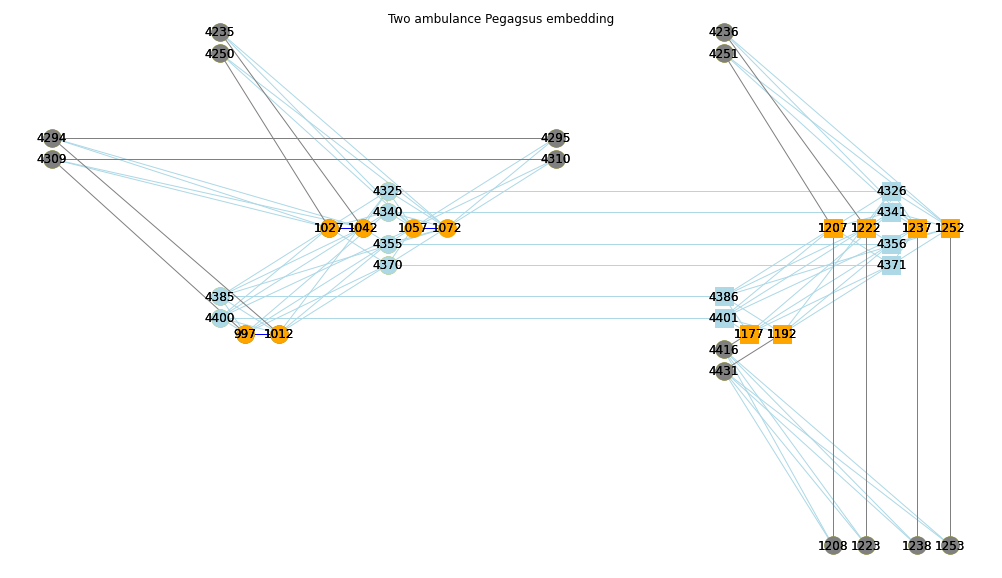

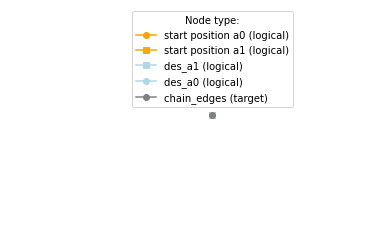

In [40]:
#DRAW active part of the full pegasus graph  - EMBEDDING
import dwave_networkx as dnx
import matplotlib.pyplot as plt
################### NODES of start and destination positions of a0 and a1 ###################
# Destinations positions for A0 'lightyellow'
#nodes_66_h_a0 = [v for v in range(3363,3363+15*6,15)]
# Create graph
des_a0_nodes = dnx.pegasus_graph(16,node_list=nodes_66_h_a0)
# Start positions for A0 'yellow'
#nodes_66_v_a0 = [v for v in range(692,692+15*6,15)]  
start_a0_nodes = dnx.pegasus_graph(16,node_list=nodes_66_v_a0)
# Destinations positions for A1

des_a1_nodes = dnx.pegasus_graph(16,node_list=nodes_66_h_a1)
# Start positions for A1
Start_first = 872

start_a1_nodes = dnx.pegasus_graph(16,node_list=nodes_66_v_a1)


#################### SIZE of graph and remove spines ###################
plt.ion()
fig, ax = plt.subplots()
plt.suptitle("Two ambulance Pegagsus embedding")
ax. set_frame_on(False)
ax. tick_params(axis='both',labelcolor='w')
ax. tick_params(axis='both',which='both',color='white')
#start_a1_nodes.set_label('via method')  #FAILS
fig.set_figwidth(14.0)
fig.set_figheight(8.0)
#################### Draw nodes and edges of fully connected (start to des) nodes for a0 and for a1 ####################

if 1:
    #################### Draw EDGES that are in Adjacency ####################     
    #nodes_in_structure_graph  = dnx.pegasus_graph(16, node_list=nodes_in_structure    )
    #dnx.draw_pegasus(nodes_in_structure_graph, with_labels=True,crosses=True, node_color='r', edge_color='white', width=1)
    #edge_target_list+=line_ext_edges
    Adjacency_edges = dnx.pegasus_graph(16, edge_list=edge_target_list)
    dnx.draw_pegasus(Adjacency_edges, with_labels=True,crosses=True, node_color='y', edge_color='lightblue', width=1)
    
    
if 0: 
    #COLOR and SHAPE edges and nodes are in Pegasus(16) 
    edges_66_vh_a0 = [(v,h) for v in nodes_66_v_a0 for h in nodes_66_h_a0]
    edges_66_vh_a1 = [(v,h) for v in nodes_66_v_a1 for h in nodes_66_h_a1]

    edge_graph_a0 = dnx.pegasus_graph(16, edge_list=edges_66_vh_a0)
    edge_graph_a1 = dnx.pegasus_graph(16, edge_list=edges_66_vh_a1)
    dnx.draw_pegasus(edge_graph_a0, crosses=True, node_color='y', edge_color='yellow', width=1)    
    dnx.draw_pegasus(edge_graph_a1, crosses=True,node_shape='*',style='dashed', edge_color='green', width=1)    
#################### Draw EDGES that create chains #################### 
if 1:
     chains_graph = dnx.pegasus_graph(16, edge_list=chain_edges)
     dnx.draw_pegasus(chains_graph,with_labels=True, crosses=True, node_color='grey', edge_color='grey', width=1)    #lightred

node_size_my=20 #node_size = node_size_my,
# Draw destinations 
dnx.draw_pegasus(des_a0_nodes,with_labels=True,crosses=True, node_color='lightblue', label='des_a0_nodes', edge_color='w', width=1)  
#'r','b','w','y','g','lightblue' NOT 
dnx.draw_pegasus(des_a1_nodes,with_labels=True, node_shape='s', crosses=True, node_color='lightblue', edge_color='w', width=1) 
# Draw start nodes
dnx.draw_pegasus(start_a0_nodes,with_labels=True, crosses=True  ,node_color='orange', edge_color='b', width=1) 
dnx.draw_pegasus(start_a1_nodes,with_labels=True, node_shape='s', crosses=True, node_color='orange', edge_color='w', width=1)  
a2=0
if a2:
    #Experimental ambulance
    Start_first_a2 = 693 
    #start positions A1
    nodes_66_v_a2 = [v for v in range(Start_first_a2,Start_first_a2+15*6,15)]
    Start_first_a2 = 768 + 15
    nodes_66_v_a2 += [v for v in range(Start_first_a2,Start_first_a2+15*6,15)]
    Des_first_a2 = 3469+15
    nodes_66_h_a2 = [v for v in range(Des_first_a2,Des_first_a2+15*4,15)] + [v for v in range(Des_first_a2+15*3+14,Des_first_a2+15*11+14,15)]
    nodes_66_h_a2 += [753,767] 
    Des_first_a2 = 3604 + 15
    nodes_66_h_a2 += [v for v in range(Des_first_a2,Des_first_a2+15*4,15)] + [v for v in range(Des_first_a2+15*3+14,Des_first_a2+15*11+14,15)]
    #print(embedding, nodes_66_h_a2)
    start_a2_nodes = dnx.pegasus_graph(16,node_list=nodes_66_v_a2)
    des_a2_nodes = dnx.pegasus_graph(16,node_list=nodes_66_h_a2)
    dnx.draw_pegasus(start_a2_nodes,with_labels=True, crosses=True  ,node_color='red', edge_color='b', width=1)     
    dnx.draw_pegasus(des_a2_nodes,with_labels=True, crosses=True  ,node_color='grey', edge_color='b', width=1)     

##################### draw legend ####################
if 1:
    fig1, ax1 = plt.subplots()
    ax1. set_frame_on(False)
    ax1. tick_params(axis='both',labelcolor='w')
    ax1. tick_params(axis='both',which='both',color='white')
    start_a0 =plt.plot(0, 0, color='orange',  marker='o', label='start position a0 (logical)') 
    line1 =plt.plot( color='orange', marker='s', label='start position a1 (logical)') 
    start_a1 =plt.plot(0, 0, color='orange',  marker='s', label='start position a1 (logical)') 
    des_a1 = plt.plot(0, 0, color='lightblue',  marker='s', label='des_a1 (logical)') 
    des_a0 = plt.plot(0, 0, color='lightblue',  marker='o', label='des_a0 (logical)') 
    chain_edges_legend = plt.plot(0, 0, color='grey',  marker='o', label='chain_edges (target)') 
    plt.legend(title='Node type:',loc='upper center') 

In [41]:
# typical chain breaks per occurance in top 1000 occurances ranked by energy =  0.015
RC_embedding = {12: (997, 4309, 4310), 13: (1012, 4294, 4295), 14: (1027, 4250), 15: (1042, 4235), 16: (1057,), 17: (1072,), 0: (4325,), 1: (4340,), 2: (4355,), 3: (4370,), 4: (4385,), 5: (4400,), 18: (1177, 4416), 19: (1192, 4431), 20: (1207, 4251, 1208), 21: (1222, 4236, 1223), 22: (1237, 1238), 23: (1252, 1253), 6: (4326,), 7: (4341,), 8: (4356,), 9: (4371,), 10: (4386,), 11: (4401,)}



DWave_pegasus_embedding1 = {0: (2661,), 6: (4064, 2556), 13: (4169, 2736), 14: (4154, 2706), 15: (4124, 4123), 16: (4139, 4138), 17: (2631, 4199), 19: (2585,), 20: (4003, 2571, 2495), 21: (3958, 2615), 22: (2600,), 23: (4034, 2660), 2: (2721, 2722), 3: (2781, 2780), 4: (2646, 2645), 5: (2691,), 12: (4184, 2616), 1: (2676, 2675), 7: (4019, 4018), 18: (2630, 4093), 8: (4049,), 9: (3974, 3973), 10: (3943,), 11: (4079,)} 

# typical chain breaks per occurance in top 1000 occurances ranked by energy =  0.0190


In [23]:
# an embedding that had a low (0.72)number of breaks in the first 1000 lowest energy occurances.
DWave_chimera_embedding = {0: (1163, 1291, 1035), 6: (1286, 1294, 1288, 1416), 13: (1043, 1171, 1047, 1039), 14: (1172, 1164, 1180, 1179), 15: (1054, 1046, 1049, 1177, 1038), 16: (1182, 1166, 1174, 1160), 17: (1167, 1183, 1175), 19: (1281, 1409, 1537), 20: (1540, 1548, 1536, 1544), 21: (1412, 1420, 1417, 1545), 22: (1418, 1546, 1421, 1413), 23: (1411, 1539, 1283, 1541), 2: (1162, 1290, 1034, 1292), 3: (1161, 1289, 1033, 1293), 4: (1297, 1169, 1041, 1425, 1553), 5: (1298, 1170, 1042, 1426, 1554), 12: (1165, 1173, 1168, 1040), 1: (1306, 1178, 1181, 1434, 1562), 7: (1549, 1557, 1565), 18: (1419, 1547, 1414, 1422), 8: (1284, 1282, 1410), 9: (1285, 1280, 1408), 10: (1542, 1550, 1558), 11: (1543, 1551, 1559)}
# an embedding that had a low (0.002)number of breaks in the first 1000 lowest energy occurances.
DWave_chimera_embedding1 ={0: (1765, 1762, 1773), 6: (1895, 1890), 13: (1635, 1644, 1636, 1763), 14: (1768, 1775, 1640), 15: (1758, 1626, 1766, 1774, 1754), 16: (1756, 1764, 1772, 1752, 1624), 17: (1629, 1645, 1637, 1634), 19: (2019, 1891, 2021, 2029), 20: (1909, 1901, 1905, 2033, 1893), 21: (1892, 1900, 1908, 1904, 2032), 22: (1896, 2024, 1902, 1894), 23: (2028, 2020, 2036, 2018), 2: (1633, 1761), 3: (1642, 1770), 4: (1643, 1771), 5: (1760, 1632, 1767), 12: (1630, 1646, 1638), 1: (1769, 1641), 7: (1897, 2025), 18: (2031, 2039, 2023), 8: (1889, 2017), 9: (1898, 2026), 10: (1899, 2027), 11: (1888, 2016)} 

embedding = DWave_chimera_embedding1
chain_edges   = get_chains_from_embedding( structured_sampler, embedding) 
edge_target_list = get_target_edges_from_logical( structured_sampler, embedding,  Adjacency)
#nodes_not_in_sampler, holes_in_focus,qpu_focus = sampler_node_not_in_chimera_graph(structured_sampler)

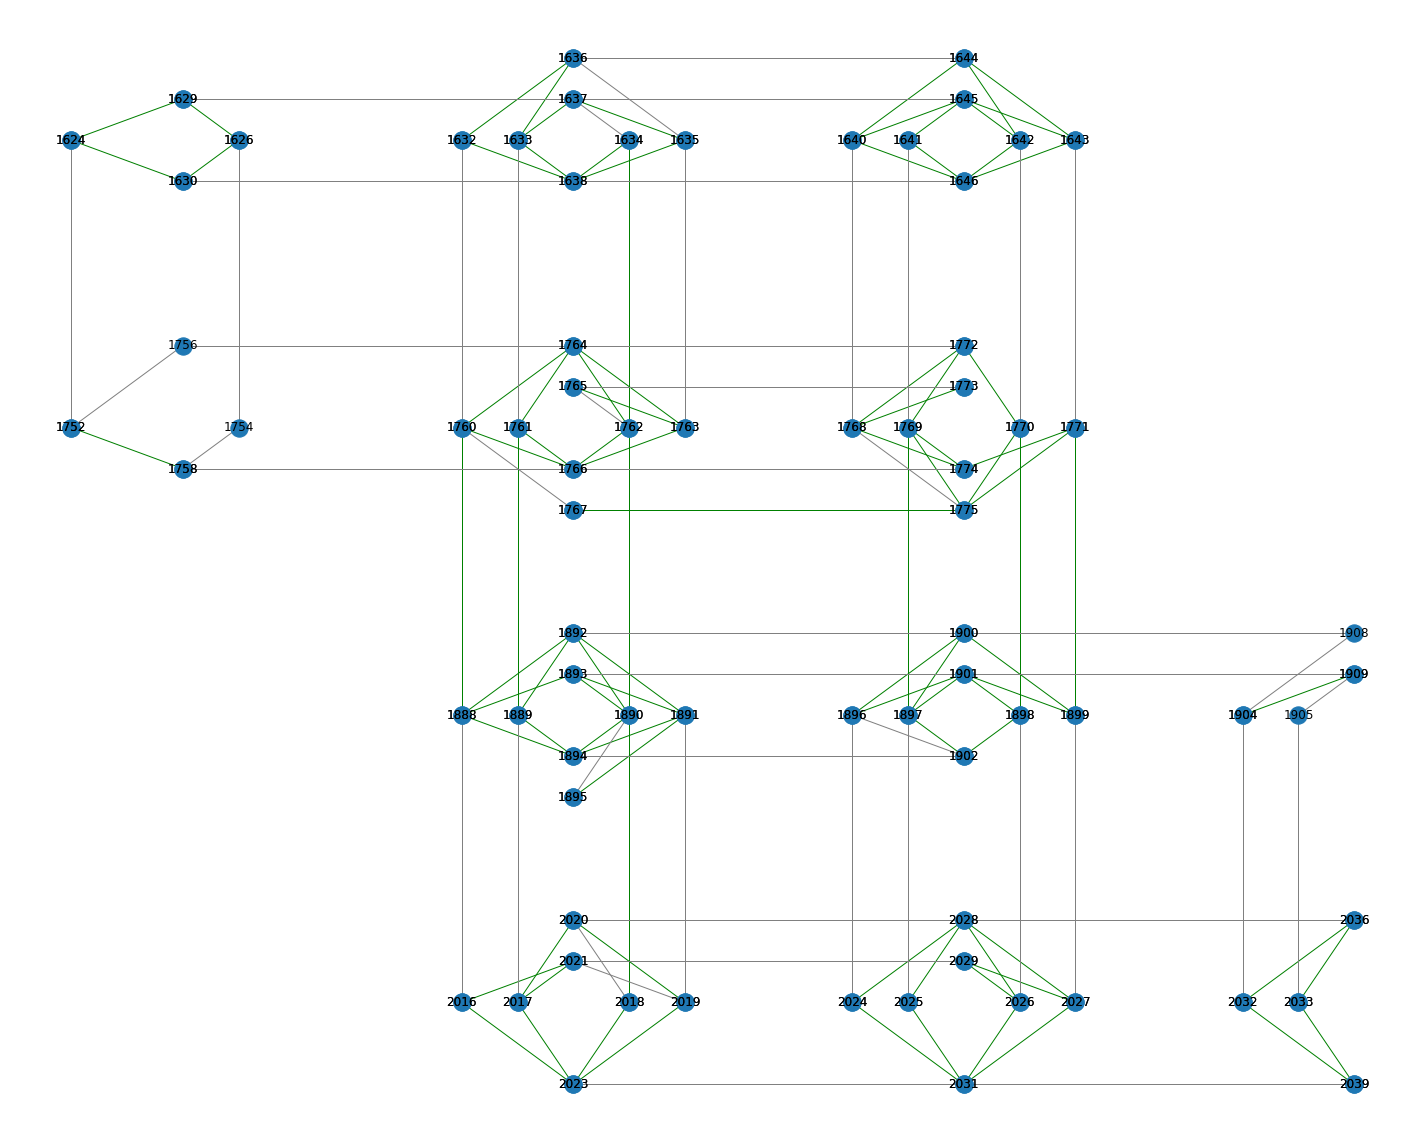

In [31]:
draw = 1 
if draw:
    #qpu_graph = dnx.chimera_graph(16,16,edge_list=qpu_focus)
    #holes_graph = dnx.chimera_graph(16,16,edge_list=holes_in_focus)
    #missing_nodes_graph = dnx.chimera_graph(16,16,node_list=nodes_not_in_sampler)
    plt.ion()
    fig, ax = plt.subplots()
    ax. set_frame_on(False)
    ax. tick_params(axis='both',labelcolor='w')
    ax. tick_params(axis='both',which='both',color='white')
    fig.set_figwidth(20.0)
    fig.set_figheight(16.0)
    dnx.draw_chimera(dnx.chimera_graph(16,16,edge_list=edge_target_list), with_labels=True,  edge_color="g")
    dnx.draw_chimera(dnx.chimera_graph(16,16,edge_list=chain_edges), with_labels=True,  edge_color="grey")

    #dnx.draw_chimera(holes_graph, with_labels=True,  edge_color="r")
    #dnx.draw_chimera(qpu_graph, with_labels=True,  edge_color="Yellow", node_color='y')

    #dnx.draw_chimera(missing_nodes_graph, with_labels=True,  node_color="r")

In [17]:
# Supply the ACTUAL EMBEDDING and show it can be run on the QPU, 
import dwave.inspector

#eg embedding = {12: [722], 13: [722+15*1], 14: [722+15*2],15:[722+15*3]}   #first 4 start positions
from dwave.system.samplers import DWaveSampler
structured_sampler = DWaveSampler(solver={'qpu': True,'topology__type': 'pegasus'})#, chains=[2,3])                      

sampler = FixedEmbeddingComposite(structured_sampler, embedding)
Myqubo = dimod.BinaryQuadraticModel.from_qubo(Adjacency)
Num_readsMy=1
response = sampler.sample(Myqubo, return_embedding=True,num_reads=Num_readsMy)#,chain_strength=5)#,,anneal_schedule=anneal_scheduleMy,

print('OUTPUT:\n',response)
#print(response.info['embedding_context']['embedding'])
#dwave.inspector.show( response)
#dwave.inspector.show(Myqubo, response,sampler, dict(embedding=embedding, chain_strength=5))
#dwave.inspector.show_bqm_response(, response.info['embedding_context'])
#dwave.inspector.show_bqm_response.__doc__

OUTPUT:
    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 23 energy num_oc. ...
0  1  1  0  0  1  1  0  0  1  0  0  0  0  0  1  0  0 ...  0  -27.0       1 ...
['BINARY', 1 rows, 1 samples, 24 variables]


In [20]:
#This cell creates a Ising model, from a qubo defined adjacency, where the starting positions of the two  ambulances have been specified by the user
# eg Amulance 'zero' starts location number 4 so set A0_fix=4
#Then this cell finds the lowest energy waveform using one of three different minimisation approaches    
#Cell 3 Finds the minimum energy for a given starting postion of two ambulances, using a choice of a)dimod.ExactSolver() b)neal.SimulatedAnnealingSampler()   or c) DWaveSampler()
UseHybrid = 0
sampler_choice = ['samplerExact','simAnneal','DWave_pegasus','DWave_chimera', 'Tabu']
Method = sampler_choice[2]
Num_readsMy = 1000     # SolverFailureError: The parameter num_reads must be within [1, 10000] for the qpu
my_prefactor = 1.41#1.414 default value
use_Composite_embedding = 0 # use sampler = EmbeddingComposite(child_sampler=structured_sampler) otherwise,  supply a working embedding of the problem, eg embedding = {12: (997, 4309, 4310), 13: (1012, 4294, 4295), ...} and use  FixedEmbeddingComposite(structured_sampler, embedding)
embedding = DWave_pegasus_embedding1
if 1: embedding = RC_embedding

use_anneal_schedule = 1
anneal_scheduleMy = [[0,0],  [20, 1]] #[10, 0.4], [40, 0.6],
################# Main minimisation of the subproblem #################
from datetime import datetime
from pyaqc.RCModules.TwoAmbulanceAnalysis import *
tstart = datetime.now()
if Height==2 and Width==2:
    A0_fix = 1
    A1_fix = 2
if Height==3 and Width==3:
    A0_fix = 1
    A1_fix = 7
if Height==5 and Width==5: #On inspection 7, 17 is the optimized distance start positions for 5*5
    A0_fix = 7 #22                          # a 10*5 grid has a more obvious solution by inspection 22,27
    A1_fix=  17 # 27#  16,32  40  
if Height==7 and Width==7:      #I need to check this is the optimum position of the ambulances
    A0_fix = 16
    A1_fix = 32                   
ConstraintMet = 1
Nlocs = Height*Width
MinE = 0

if UseHybrid:
    AdjacencyHybrid = create_hybrid_from(Adjacency, Nlocs,A0_fix ,A1_fix )
    Myqubo = dimod.BinaryQuadraticModel.from_qubo(AdjacencyHybrid)       #use quboHybrid with given A0_fix and A1_fix
else:
    Myqubo = dimod.BinaryQuadraticModel.from_qubo(Adjacency)             #use Adjacency with all starting positions

############ Use one of three possible samplers
    # a)samplerExact(calculated every possible combination of ambulance start positions)
    # b)SimulatedAnnealingSampler()  (classically imitates a Dwave annealer)
    # c)sampler = EmbeddingComposite(DWaveSampler()) , the real online Dwave annealer

if Method == sampler_choice[0]:       # 'samplerExact'
    response = samplerExact.sample(Myqubo) 
    Num_readsMy = 1
    energy = response.first[1]
    
if Method == sampler_choice[1]: # Method == 'simAnneal'
    import neal
    solver = neal.SimulatedAnnealingSampler()  
    response = solver.sample(Myqubo, num_reads=Num_readsMy)
    plt.plot(response.data_vectors['energy'])


from dwave.system import FixedEmbeddingComposite
from dwave.system.samplers import DWaveSampler
from dwave.system.composites  import EmbeddingComposite

#### select sampler from  'DWave_pegasus','DWave_chimera'

if Method == sampler_choice[2]: # DWAVE online annealing Method = 'DWave_pegasus'
    structured_sampler = DWaveSampler(solver={'topology__type': 'pegasus'})        #'chimera ', 'pegasus'
    
if Method == sampler_choice[3]: # DWAVE online annealing Method = 'DWave_chimera' with anneal_scheduleMy
    structured_sampler = DWaveSampler(solver={'topology__type': 'chimera'})      #'chimera ', 'pegasus'
    
if (Method == sampler_choice[2] or  Method == sampler_choice[3]) and 1:
    #### Set Chain strength
    from dwave.embedding.chain_strength import uniform_torque_compensation      #prefactor * rms * math.sqrt(avg_degree)
    if my_prefactor > 0:
        chain_strength_value = uniform_torque_compensation(Myqubo.spin, embedding=None, prefactor=my_prefactor)
    else:
        chain_strength_value = 1
    
    #### Set embedding
    if use_Composite_embedding :
        sampler = EmbeddingComposite(structured_sampler)
    else:
        sampler = FixedEmbeddingComposite(structured_sampler, embedding)
    if use_anneal_schedule:
        response = sampler.sample(Myqubo, num_reads=Num_readsMy,return_embedding=True,chain_strength=chain_strength_value,anneal_schedule=anneal_scheduleMy)#, anneal_schedule=anneal_scheduleMy)
    else:
        response = sampler.sample(Myqubo, num_reads=Num_readsMy,return_embedding=True,chain_strength=chain_strength_value)
from tabu import TabuSampler
if Method == sampler_choice[4]:     #'Tabu'
    response = TabuSampler().sample(Myqubo, num_reads=Num_readsMy)
TimeTaken = (datetime.now() - tstart).seconds
print(TimeTaken, '= Time taken (secs) by', Method)    

# Find Start positions in the solution
psi_opt = list( response.first[0].values())
if not UseHybrid and 1:
    A0_sol  =   Grid_StartPositionsAO(psi_opt,  Height,Width)
    A1_sol  =   Grid_StartPositionsA1(psi_opt,  Height,Width)
else:
    A0_sol = A0_fix
    A1_sol  = A1_fix
Print_Destinations(response, Height,Width,Method, A0_sol, A1_sol,show_start_pos=1)
if A0_sol>=0 and  A1_sol>=0:
    Distance = SolutionDistance(psi_opt,A0_sol,A1_sol,Adjacency,Nlocs)
    print('Distance of solution = ', Distance, end='')
else:
    print('Start positions not found')
    Distance = -1
print( '\tWith A0_sol =',A0_sol,'and A1_sol =',A1_sol)
print( ' ConstraintMultiplier/max_distance = ', ConstraintMultiplier/max_distance  )
if 1:
    repeats = lowest_energy_num_occ(response,0.01)
    print(repeats, " = number of occurances of the lowest energy found. Using num_shots =  {0:4} ".format( Num_readsMy )  )
    print('%3.2f'%(repeats*100/Num_readsMy), '= % Probability that this energy level was found by one anneal, ie num_shot=1')
    print(len(response.data_vectors['energy']), 'len (List of  energies UNORDERED)')

    print(              '{:15} {:15} {:15}{:15}{:15}{:15}{:15}{:15}{:15}{:15}'.format('Grid','Energy', 'Distance', 'Errs','Constraintmet','Method', 'Lagrange K', 'num_reads ', 'time', 'my_prefactor'),end=''  )
    print("\n|{:<2} {:<1}{:<1}|{:>14}|{:15}|0 |{:>15}|{:>15s}| {:15}|{:15}|{:15}|".format(Width,'* ',Height,response.first[1],Distance,ConstraintMet, Method,ConstraintMultiplier/max_distance,Num_readsMy,TimeTaken) ,end='')
    print(repeats,'(', '%3.2f'%(repeats*100/Num_readsMy),'%)|', '%3.2f'%my_prefactor,'|')
if 0:
    print(response.info['embedding_context']['chain_strength']  )

2 = Time taken (secs) by DWave_chimera
StartPositionsA0
[0, 1, 0]
[0, 0, 0]
			 Start Position A0 Constraints met
StartPositionsA1
[0, 0, 0]
[0, 1, 0]
 			Start Position A1 Constraints met
-29.0  = Lowest energy found by DWave_chimera  in a grid 3 (w) by 2 (h)
Destination Constraints were Met.
 Map of destinations of each ambulance, 1 for A0, 0 for A1. Where A0 starts add 10, A1 add 20
[1, 10, 1]
[0, 21, 0]
Distance of solution =  -9.0	With A0_sol = 1 and A1_sol = 4
 ConstraintMultiplier/max_distance =  0.5
255  = number of occurances of the lowest energy found. Using num_shots =  9000 
2.83 = % Probability that this energy level was found by one anneal, ie num_shot=1
1390 len (List of  energies UNORDERED)
Grid            Energy          Distance       Errs           Constraintmet  Method         Lagrange K     num_reads      time           my_prefactor   
|3  * 2|         -29.0|           -9.0|0 |              1|  DWave_chimera|             0.5|           9000|              2|255 ( 2.

In [ ]:
usind AddDistance = 2 make the range of distances centered on zero 
gnd state prob was lower as a result for pegasus and chimera
|3  * 2|         -49.0|           -9.0|0 |              1|  DWave_pegasus|       1.0|           9000|              1|84 ( 0.93 %)| 1.41 |
# offset is after max_distance is calculated

'chain_strength': 3.27
|3  * 2|         -29.0|           -9.0|0 |              1|  DWave_pegasus,0.0160|  0.5|           9000|              3|80 ( 0.89 %)| 1.41 |
DWave_chimera
|3  * 2|         -29.0|           -9.0|0 |              1|  DWave_chimera0.0116|  0.5|           9000|              2|255 ( 2.83 %)| 1.41 |

In [22]:
# Display chain break for each potential solution in order of 'energy'
print(response.first[3])        #chain break fraction in that sample
print('UNPACK each sample from the sampleSet, in ORDER of (energy, or of evaluations)  into\n', 'Sample', '\t\t\t\t\t\tenergy','\tnum_occurrences', 'chain_break_fraction')
# 'chain_break_fraction' definition = for a given suggested solution, the number of chains broken / n_qubits
avg_num_chain_breaks = 0
sum_num_occurrences = 0
max_occurances = 1000
for n,datum in enumerate( response.data(fields=['sample', 'energy','num_occurrences','chain_break_fraction'], sorted_by='energy')):     #'energy''chain_break'
    if sum_num_occurrences < max_occurances:
        if n<10 or 0:
            print(list(datum.sample.values() ), '\t', datum.energy ,'\t', datum.num_occurrences,'\t',datum.chain_break_fraction)
        avg_num_chain_breaks += n_qubits * datum.chain_break_fraction * datum.num_occurrences
        sum_num_occurrences += datum.num_occurrences
print( '%3.4f'%(avg_num_chain_breaks/ (sum_num_occurrences )) , '=  avg_num_chain_breaks for  the lowest energy suggested solutions in the first ', max_occurances,'occurances')


0.0
UNPACK each sample from the sampleSet, in ORDER of (energy, or of evaluations)  into
 Sample 						energy 	num_occurrences chain_break_fraction
[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 	 -29.0 	 216 	 0.0
[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 	 -29.0 	 1 	 0.041666666666666664
[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 	 -29.0 	 1 	 0.041666666666666664
[0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0] 	 -29.0 	 37 	 0.0
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0] 	 -28.5 	 11 	 0.041666666666666664
[0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0] 	 -28.5 	 16 	 0.0
[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0] 	 -28.5 	 836 	 0.0
0.0116 =  avg_num_chain_breaks for  the lowest energy suggested solutions in the first  1000 occurances


In [18]:
# check the embedding used was of my own design RC_embedding
print( embedding,'\n\n')
#print(DWave_chimera_embedding1,'\n\n')
print(response.info['embedding_context']['embedding'], '\n\n hi')
print(response.info['timing']['qpu_anneal_time_per_sample'] , ' = qpu_anneal_time_per_sample')

response.info['embedding_context']

{12: (997, 4309, 4310), 13: (1012, 4294, 4295), 14: (1027, 4250), 15: (1042, 4235), 16: (1057,), 17: (1072,), 0: (4325,), 1: (4340,), 2: (4355,), 3: (4370,), 4: (4385,), 5: (4400,), 18: (1177, 4416), 19: (1192, 4431), 20: (1207, 4251, 1208), 21: (1222, 4236, 1223), 22: (1237, 1238), 23: (1252, 1253), 6: (4326,), 7: (4341,), 8: (4356,), 9: (4371,), 10: (4386,), 11: (4401,)} 


{12: (997, 4309, 4310), 13: (1012, 4294, 4295), 14: (1027, 4250), 15: (1042, 4235), 16: (1057,), 17: (1072,), 0: (4325,), 1: (4340,), 2: (4355,), 3: (4370,), 4: (4385,), 5: (4400,), 18: (1177, 4416), 19: (1192, 4431), 20: (1207, 4251, 1208), 21: (1222, 4236, 1223), 22: (1237, 1238), 23: (1252, 1253), 6: (4326,), 7: (4341,), 8: (4356,), 9: (4371,), 10: (4386,), 11: (4401,)} 

 hi
20  = qpu_anneal_time_per_sample


{'embedding': {12: (997, 4309, 4310),
  13: (1012, 4294, 4295),
  14: (1027, 4250),
  15: (1042, 4235),
  16: (1057,),
  17: (1072,),
  0: (4325,),
  1: (4340,),
  2: (4355,),
  3: (4370,),
  4: (4385,),
  5: (4400,),
  18: (1177, 4416),
  19: (1192, 4431),
  20: (1207, 4251, 1208),
  21: (1222, 4236, 1223),
  22: (1237, 1238),
  23: (1252, 1253),
  6: (4326,),
  7: (4341,),
  8: (4356,),
  9: (4371,),
  10: (4386,),
  11: (4401,)},
 'chain_break_method': 'majority_vote',
 'embedding_parameters': {},
 'chain_strength': 3.273698453202433}

In [ ]:
2.00  = average chain length. 3  = max_len.

{0: (3061, 345, 435),
 6: (3016, 3017),
 13: (3091, 330, 3121),
 14: (406, 3152),
 15: (420, 3076),
 16: (3031, 465),
 17: (361, 3196),
 19: (3092, 495),
 20: (3047, 525),
 21: (570, 571),
 22: (3062, 585),
 23: (3077, 555),
 2: (360, 2971),
 3: (3136, 3137),
 4: (390, 391),
 5: (3122,),
 12: (450, 3046),
 1: (3181,),
 7: (600, 3182),
 18: (540, 3032, 541),
 8: (2972, 2973),
 9: (510,),
 10: (2987, 2988),
 11: (3123, 615)}

22: (782, 781, 3438)  
Looks like the Adjacency edge values have been scaled by 0.25.  
chain_strength = -5.72  
On the inspector the darker the line the stronger its edge value

|Logical Node #|Src node|Src edge|Adjacency edge|'        '|Chain      |Target edge embedded| Target node|
|:-----------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|
|19           |-10     |6.66    |10      |        |   752, 3423|0.83+0.83 +0.83=2.5 |  5.875+5.875|
|23           |-10.83  | 10     |10      |         |767, 3273|1.25+1.25=2.5|6.625+|
|7            |       |1        |1       |         |3289, 3288|0.25|        
|8            |       |2        |2       |         |3319, 3318|0.5|        
|9            |       |1        |1       |         |3348, 3349|0.25|        

In [31]:
# DWave_pegasus_embedding   1.96  = average chain length. 3  = max_len.
# second embedding 1.71  = average chain length. 3  = max_len
# DWave_chimera_embedding   3.08  = average chain length. 5  = max_len. n* k(4,4) 4 internal (to the 4*4) edges,  and 2 external, length 4 degree 6
# 'target QPU' is real embedding, light grey edges are the chain dark grey are logical edges/couplings
# 'source' is logical qubits and edges, with notes if there is a chain.
DWave_pegasus_embedding = {0: (237, 5131),
 6: (5220, 162),
 13: (238, 5281),
 14: (252, 5190),
 15: (281, 282),
 16: (5221, 312, 313),
 17: (327, 5236, 328),
 19: (5280,),
 20: (118, 117),
 21: (5250, 208),
 22: (5475, 148, 147),
 23: (5265, 102),
 2: (357, 5146),
 3: (5311,),
 4: (5355, 163),
 5: (5340,),
 12: (296, 297),
 1: (192, 5175),
 7: (177, 5235),
 18: (5295,),
 8: (5145, 132),
 9: (5310, 87),
 10: (5325, 58),
 11: (5400, 193)}
# 3.08  = average chain length. 5  = max_len.
DWave_chimera_embedding = {0: (920, 792),
 6: (1048, 1176),
 13: (783, 799, 791, 785),
 14: (782, 798, 790, 787),
 15: (924, 916, 908, 921, 793),
 16: (780, 788, 796, 777),
 17: (781, 797, 789),
 19: (1045, 1053, 1037, 1040),
 20: (1177, 1049, 1173, 1181),
 21: (1038, 1054, 1046, 1043),
 22: (1052, 1036, 1044),
 23: (1039, 1055, 1047, 1041),
 2: (776, 904),
 3: (923, 795),
 4: (786, 914),
 5: (794, 922),
 12: (919, 911, 912, 784, 927),
 1: (779, 907),
 7: (1163, 1035, 1165),
 18: (1162, 1166, 1174, 1182, 1034),
 8: (1032, 1160),
 9: (1051, 1179),
 10: (1170, 1042),
 11: (1050, 1178)}
total = 0
n=0
max_len = 0
DWave_pegasus_embedding = response.info['embedding_context'] ['embedding']
for key, val in DWave_pegasus_embedding.items():
    max_len = max(max_len,len(val))
    total += len(val)
    n += 1
print('%3.2f'%(total/n), ' = average chain length.', max_len, ' = max_len.')


3.12  = average chain length. 5  = max_len.
{0: (1765, 1762, 1773), 6: (1895, 1890), 13: (1635, 1644, 1636, 1763), 14: (1768, 1775, 1640), 15: (1758, 1626, 1766, 1774, 1754), 16: (1756, 1764, 1772, 1752, 1624), 17: (1629, 1645, 1637, 1634), 19: (2019, 1891, 2021, 2029), 20: (1909, 1901, 1905, 2033, 1893), 21: (1892, 1900, 1908, 1904, 2032), 22: (1896, 2024, 1902, 1894), 23: (2028, 2020, 2036, 2018), 2: (1633, 1761), 3: (1642, 1770), 4: (1643, 1771), 5: (1760, 1632, 1767), 12: (1630, 1646, 1638), 1: (1769, 1641), 7: (1897, 2025), 18: (2031, 2039, 2023), 8: (1889, 2017), 9: (1898, 2026), 10: (1899, 2027), 11: (1888, 2016)}


In [ ]:

"""
Record of actual problems submitted on line ie to the DWAVEQPU compared to the SimulatedAnnealingSampler

DWAVEQPU solutions:
#4*3 solution, this means W=4 and H=3 hence there are 12 possible locations to start from.
  0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1] = psi_opt first ambulance destinations 
 [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0] = psi_opt 2nd ambulance destinations -7690.0 in 15 msecs
 
 9*9                    1858         yes        DWAVEQPU       sum_distance              20            16ms
 10*10      embedding found(10*10*2+2= 202)      more qubits than 7*7*4
 11*11      embedding found(11*11*2+2= 244)      more qubits than 7*7*4  so perhaps highly connected nature of start/distance is problem
A0_fix = 22 A1_fix = 27 I have found best Distance of solution for 11*11, by inspection, = 200 



A0_fix = 16 A1_fix = 32 12.35pm
9*9   -14520154.0       1526      yes           simAnneal   sum_distance                  1000
A0_fix = 22 A1_fix = 27 I have found best Distance of solution, by inspection, = 200 
10*5                    450       yes           simAnneal   sum_distance                  50000
10*5                    425       yes           simAnneal   sum_distance                  50000
10*5                    385       yes           simAnneal   max_distance *10              50000
10*5                    365       yes           simAnneal   max_distance *10              50000
"""



In [47]:
#1) make a Adjacency with just Start positions and Destinations of A0 for DEBUG
# remove all ref to nodes 6-11 and >17, ie  not 0-5 or 12-17
# remove nodes (12-17,12-17)
remove = []
for (q1,q2) in Adjacency.keys():
    # remove all ref to nodes 6-11 and >17, ie  not 0-5 or 12-17
    if q1 > 17 and q2 > 17:
        remove.append( (q1, q2) )
    if 0:        
        if (q1 > 5 and q1 < 12) or (q2 > 5 and q2 < 12)  or q1 > 17 or q2 > 17:
            remove.append( (q1, q2) )
        # remove nodes (12-17,12-17)
        if (q1 >= 12 and q1 <= 17) and (q2 >= 12 and q2 <= 17) :
            remove.append( (q1, q2) )
        # remove nodes (12-17,12-17)
        if (q1 >= 12 and q1 <= 17) and (q2 >= 12 and q2 <= 17) :
            remove.append( (q1, q2) )
for   (q1,q2) in remove:
    del Adjacency[(q1,q2)]
print_QUBOdetails(Adjacency,n_qubits,filename)

ADJACENCY MATRIX Twoambulances.txt  

Qubit  q0   q1   q2   q3   q4   q5   q6   q7   q8   q9  q10  q11  q12  q13  q14  q15  q16  q17  q18  q19  q20  q21  q22  q23 

  q0   -5                            10                                 1    4    1    2    5  

  q1        -5                            10                       1         1    2    1    2  

  q2             -5                            10                  4    1         5    2    1  

  q3                  -5                            10             1    2    5         1    4  

  q4                       -5                            10        2    1    2    1         1  

  q5                            -5                            10   5    2    1    4    1  

  q6                                 -5                                                               1    4    1    2    5  

  q7                                      -5                                                     1         1    2    1    2  

  q8

In [ ]:
Fixed starting positions ie UseHybrid = 1
Grid            Energy          Distance       Constraintmet  Method         Lagrange K     num_reads      time 

3  * 3        -871.0  (11.7%)            9                   1       DWAVEQPU            10.0           9000              5

In [5]:
# To reduce the qubits used, select the ambulance STARTING POSITIONS, (n(n-1))/2 of them, CLASSICALLY , calc each energy with dwave pick the lowest.
from dwave.system.samplers import DWaveSampler
from dwave.system.composites  import EmbeddingComposite
            
Nlocs = Height*Width
psi_opt =[]
MinE = 0
A0_sol = -1
A1_sol = -1
from datetime import datetime
tstart = datetime.now()
#Create a set of smaller subproblems each called 'AdjacencyHybrid' each derived from a fixed starting position of each ambulance A0_fix and A1_fix

for A0_fix in range(0,Nlocs):
    for A1_fix in range(A0_fix +1 ,Nlocs):
        AdjacencyHybrid = create_hybrid_from(Adjacency, Nlocs,A0_fix ,A1_fix ) 
        #2) Find the lowest energy of the subproblem
        Myqubo = dimod.BinaryQuadraticModel.from_qubo(AdjacencyHybrid)
        if 0: 
            response = samplerExact.sample(Myqubo) 
            Method = 'samplerExact'
        elif 1:
            Method = 'simAnneal'
            import neal
            solver = neal.SimulatedAnnealingSampler()  
            response = solver.sample(Myqubo, num_reads=Num_readsMy)
        elif 0: 
            # DWAVE online annealing Lesson 4
            sampler = EmbeddingComposite(DWaveSampler())                                    
            response = sampler.sample(Myqubo, num_reads=Num_readsMy)
            Method = 'DWAVEQPU'
        
        Distance = SolutionDistance(response.first[0],A0_fix,A1_fix,Adjacency,Nlocs)
        show_grid = 1
        if  not show_grid:
            ψ  = list( response.first[0].values() )
            print('',ψ[:Width * Height],              '= ψ  first ambulance destinations')
            A_start =[ int(not bool(n-A0_fix)) for n in range(Nlocs)]
            print(A_start , ' = start position of AO')
            print(ψ[Width * Height:2*Width * Height], '= ψ  2nd ambulance destinations', response.first[1], 'Distance = ',Distance,'\n')
            A_start =[ int(not bool(n-A1_fix)) for n in range(Nlocs)]
            print(A_start , ' = start position of A1')
        else:
            if 0:
                ψ  = Print_Destinations(response, Height,Width,Method)
            print( 'Distance = ',Distance)
            
        # print('Use both ambulance1;', datum.sample[Width * Height*2],'and ambulance2;',datum.sample[Width * Height*2+1])
        energy = response.first[1]              #This is the lowest energy found by the
        if MinE > energy:
            best_response = response
            ψ =     list( response.first[0].values() )        #a list of the waveform evaluated
            MinE = energy
            E = qubo_energy_value(ψ, AdjacencyHybrid)
            psi_opt = ψ
            A0_sol = A0_fix
            A1_sol  = A1_fix
            print(psi_opt, MinE,' A0pos =',A0_sol,' A1pos =',A1_sol, 'Distance = ',Distance )
            print((datetime.now() - tstart).seconds, '= seconds elapsed')   
#Print lowest energy from the set of all starting positions
Distance = SolutionDistance(best_response.first[0],A0_sol ,A1_sol,
print( '(Distance travelled)^2 by ambulances in solution to objective function = ',Distance)Adjacency,Nlocs)
ψ  = Print_Destinations(best_response, Height,Width,Method)

print('\nAfter ', (datetime.now() - tstart).seconds, 'seconds, Final psi:')

print('finished hybrid')

Distance =  18
[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1] -862.0  A0pos = 0  A1pos = 1 Distance =  18
1 = seconds elapsed
Distance =  18
Distance =  18
Distance =  10
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] -870.0  A0pos = 0  A1pos = 4 Distance =  10
7 = seconds elapsed
Distance =  11
Distance =  18
Distance =  11
Distance =  14
Distance =  18
Distance =  13
Distance =  9
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1] -871.0  A0pos = 1  A1pos = 4 Distance =  9
18 = seconds elapsed
Distance =  13
Distance =  11
Distance =  9
Distance =  11
Distance =  11
Distance =  10
Distance =  18
Distance =  14
Distance =  11
Distance =  18
Distance =  9
Distance =  9
Distance =  18
Distance =  13
Distance =  11
Distance =  9
Distance =  10
Distance =  9
Distance =  10
Distance =  11
Distance =  13
Distance =  18
Distance =  18
Distance =  18
Distance =  18


TypeError: SolutionDistance() takes 5 positional arguments but 6 were given

In [10]:
print( '(Distance travelled)^2 by ambulances in solution to objective function = ',Distance)Adjacency,Nlocs)
ψ  = Print_Destinations(best_response, Height,Width,Method)


-871.0  = Lowest energy found by simAnneal  in a grid 3 (w) by 3 (h)
Destination Constraints were Met. 
 Map of destinations of each ambulance, 1 for A0, 0 for A1
[1, 1, 1]
[0, 0, 0]
[0, 0, 0]
(Distance travelled)^2 by ambulances in solution to objective function =  9


In [ ]:
"""         
Grid        features    qubits  2^n            Method      Energy solution         Time/hours               Comment
3*2         *4           24     2^24 = 16m      dimod       -2367=-2374+9           2mins
3*2         *4           24     2^24 = 16m      C++         -2367=-2374+9           15mins               not faster than dimod

3*3         *4          = 36    2^36 = 69bn     C++         -2367=-2374+9           69bn/20m = 3500mins
3*3         *2 +2       = 20    (9*8)2^20 = 16m dimod/hybrid -2367=-2374+9          4 mins

c++ and ipynb gives E = -2367 = -2374 + 9 by symmetry the solution is clear so I tested that the Ising was low 
"""



In [19]:
print('CLASSICAL calculation of energies using dimod and qubo_energy_value() which should equal each other')
print('Location grid is ',Width,'wide and ',Height,'high.' )
Myqubo = dimod.BinaryQuadraticModel.from_qubo(qubo)
#THIRD calculate ENERGY of each state
tstart = datetime.now()
################ (A) calculate energy of one input state, using if 1 ################
if 0:
    #Below are three ψ solutions for location grids of 2*2, or 3*2, or 3*3 
    ψ = [1, 1, 1, 0, 0, 0, 0, 0,  0,1, 1, 1,0 ,1, 0, 0, 1, 0]  #16 qubits 2*2*4 = 16 qubits
    #   des_a0              des_a1              START_A0            START_A1
    #   0                   6                   12                  18
    ψ = [1, 1, 1, 0,0, 0   , 0, 0, 0,1, 1, 1,   1,0, 0, 0, 0, 0,    0,0, 0, 0, 1, 0]  #2*2,
    
    ψ = [1, 1, 1,1,1,0,0,0,0   , 0,0,0,0,0,1,1,1,1,   0,1,0,0,0,0,0,0,0,    0,0,0,0,0,0,0,1,0] #grid 3*2*4

    #ψ =[1, 1, 1, 0, 0, 0, 0, 0, 0  , 0, 0, 0, 1, 1, 1, 1, 1, 1,   1, 1] hybrid 3*3 gives E = -2367 takes 6 mins(3.5min not in debug mode or .ipynb) with energy = response.first[1]
    #...but 2.3 hrs with "enumerate" cycling through every energy level was costly
    E = qubo_energy_value(ψ, qubo)
    
    print('\t\t\t\t',ψ[:Width * Height],'= ψ first ambulance destinations','\n','\t\t\t\t',ψ[Width * Height:2*Width * Height],'= ψ 2nd ambulance destinations \t')
    print(ψ[2*Width * Height:3*Width * Height],'= ψ first ambulance Start position',ψ[3*Width * Height:4*Width * Height],'= ψ 2nd ambulance Start position\t', '%3.2f' %E,'= classical Energy')
else:
    ################ or (B) calculate energy of all input state, using if 0 ################
    response = samplerExact.sample(Myqubo) 
    stop =0 
    max_sol = 0
    MinE = -10000

    for n,datum in enumerate( response.data(['sample', 'energy'])):     
        if  n < 30 or 0:                                 #display lowest energy results
            for i, elem in enumerate( datum.sample):
                ψ[i] = (datum.sample[elem]) 
            #Check if Dwave energy calculation is the same as my calculation qubo_energy_value()
            E = qubo_energy_value(ψ, qubo)
    # print ERROR if the constraints have not been met. The target is for just one start postion per Ambulance, every location to be designated just one ambulance         
            if max(ψ[:Width * Height]+ ψ[Width * Height:2*Width * Height]) >1:
                print('ERROR',ψ[:Width * Height],'= ψ first ambulance destinations','\n',ψ[Width * Height:2*Width * Height],'= ψ 2nd ambulance destinations \t')
            if sum(ψ[3*Width * Height:4*Width * Height]) !=1 and sum(ψ[2*Width * Height:3*Width * Height]) !=1 and stop <20 :
                stop +=1
                print('ERROR',ψ[2*Width * Height:3*Width * Height],'= ψ first ambulance Start position',ψ[3*Width * Height:4*Width * Height],'= ψ 2nd ambulance Start position\t', '%3.2f' %E,'= classical Energy', '%3.2f' %datum.energy,'= DIMOD calc of energy n=',n)
    #print position of Ambulance start positions and destinations. 
            if MinE < datum.energy or  max_sol <5:
                max_sol += 1
                MinE = datum.energy
                print('\t\t\t\t',ψ[:Width * Height],'= ψ first ambulance destinations','\n','\t\t\t\t',ψ[Width * Height:2*Width * Height],'= ψ 2nd ambulance destinations \t')
                print(ψ[2*Width * Height:3*Width * Height],'= ψ first ambulance Start position',ψ[3*Width * Height:4*Width * Height],'= ψ 2nd ambulance Start position\t', '%3.2f' %E,'= classical Energy', '%3.2f' %datum.energy,'= DIMOD calc of energy n=',n)
print((datetime.now() - tstart).seconds)
print('Finished non-hybrid')


CLASSICAL calculation of energies using dimod and qubo_energy_value() which should equal each other
Location grid is  2 wide and  2 high.


IndexError: list assignment index out of range

    After about 1 hour it completed a 3*2 grid with 4 features, roughly 16m calcs, successfully finding the -524 energy that I expected from the simplicity of the problem. An ambulance in each corner service itself and its two neighbour represents an energy of 4 from the distance covered.

